In [3]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

from matplotlib import colors
from itertools import cycle

def my_colors():
    """
    return a tableau colors iterable
    """
    tab = cycle(colors.TABLEAU_COLORS)
    return tab

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [53]:
import os
histories = []
for root, dirs, files in os.walk("../models/"):  
    for filename in files:
        if 'history' in filename:
            if 'gen' in filename:
                if 'GDB17_mix_pure' in filename:
                    histories.append(filename)

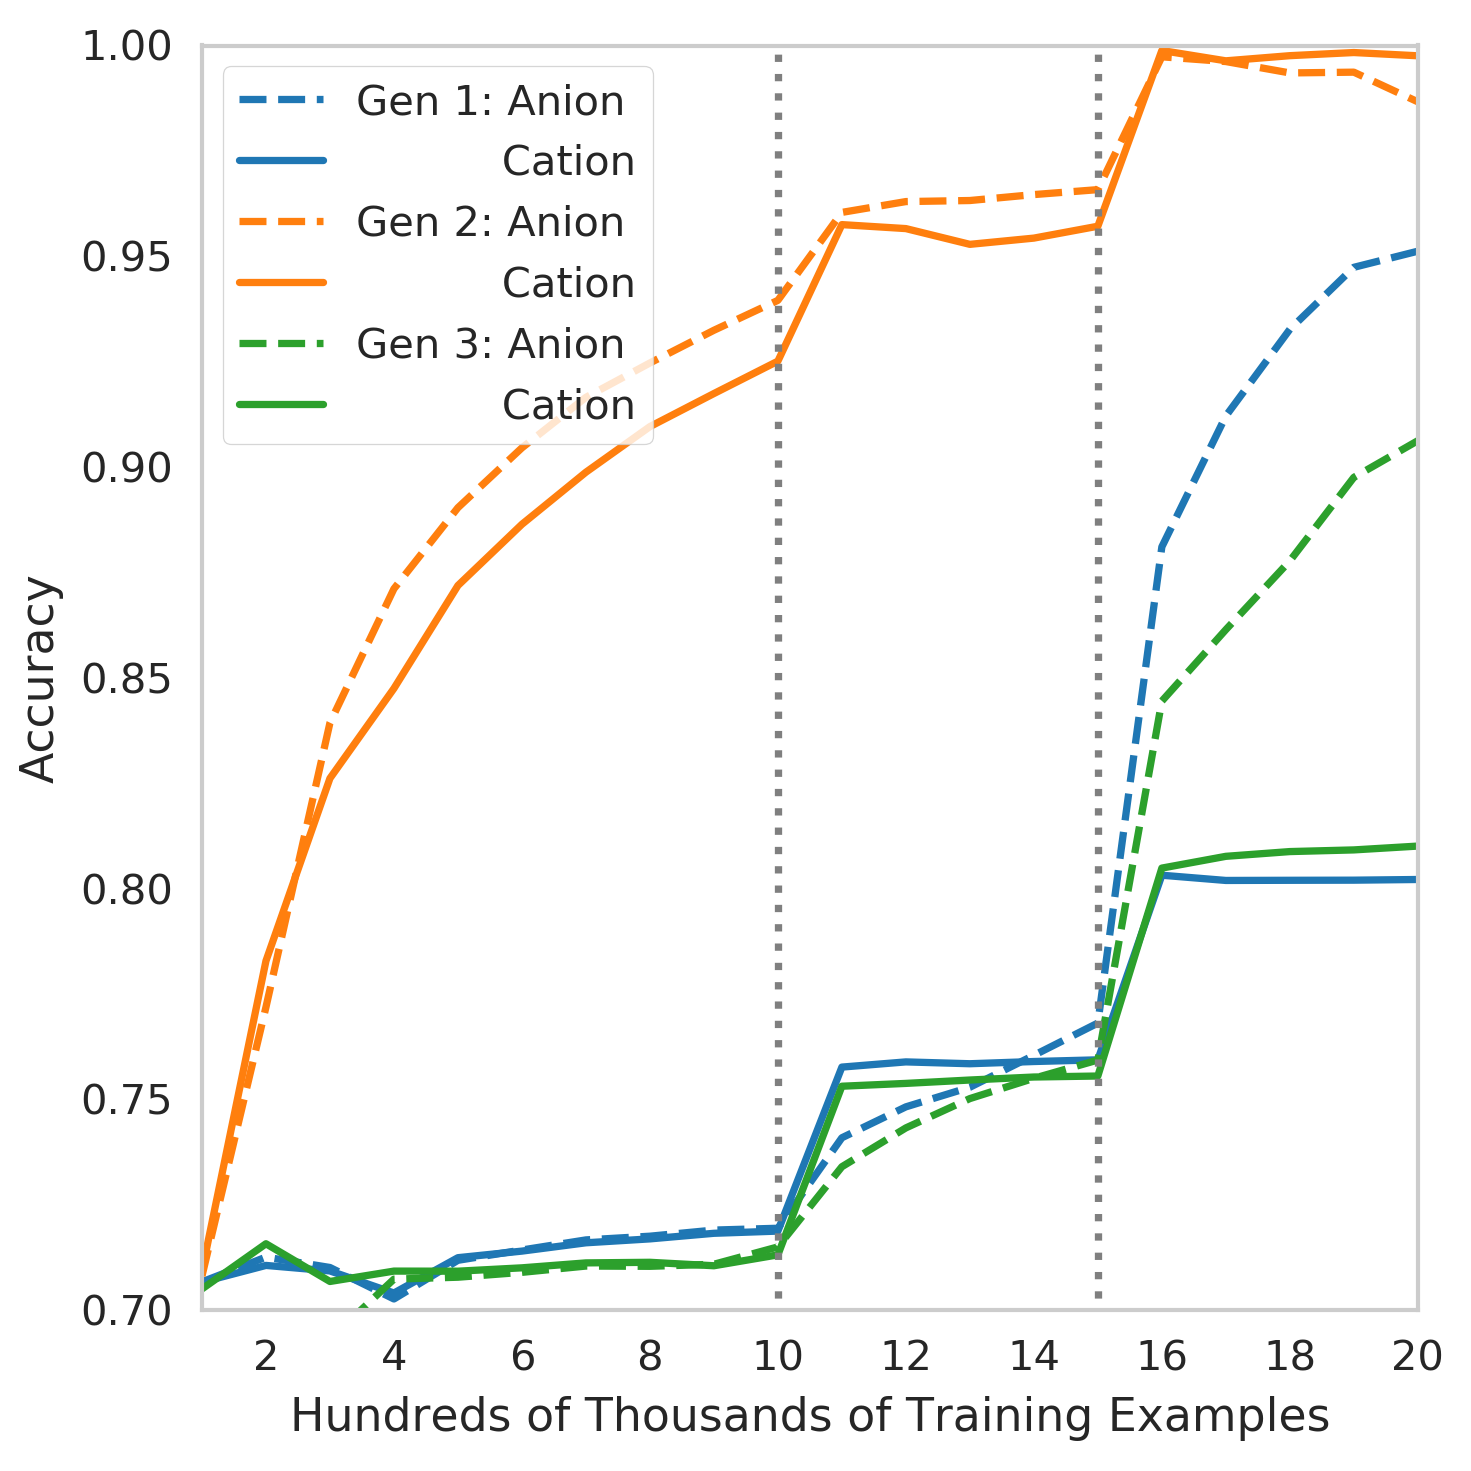

In [69]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    tab = my_colors()
    for i in range(3):
        col=next(tab)
        with open('../models/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)
        cat = []
        ani = []
        for epoch in hist:
            if i == 0:
                ani.append(epoch['decoded_anion_mean_acc'][0])
                cat.append(epoch['decoded_cation_mean_acc'][0])
            else:
                ani.append(epoch['anion_decoded_mean_acc'][0])
                cat.append(epoch['cation_decoded_mean_acc'][0])
        ax.plot(np.arange(1,21), ani, ls='--', label="Gen {}: Anion".format(i+1), c=col)
        ax.plot(np.arange(1,21), cat, ls='-', label="           Cation".format(i+1), c=col)
        ax.set_xlim(1,20,1)
        ax.set_ylim(0.7,1)
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Hundreds of Thousands of Training Examples')
        
        ax.legend(loc=2, frameon=True)
    ax.plot([10,10],[0.6,1.1], ls=':', c='tab:grey')
    ax.plot([15,15],[0.6,1.1], ls=':', c='tab:grey')
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    fig.tight_layout()
    plt.grid()


In [1]:
import os
histories = []
for root, dirs, files in os.walk("../models/"):  
    for filename in files:
        if 'history' in filename:
            if 'gen3vae' in filename:
                if '100' in filename:
                    histories.append(filename)

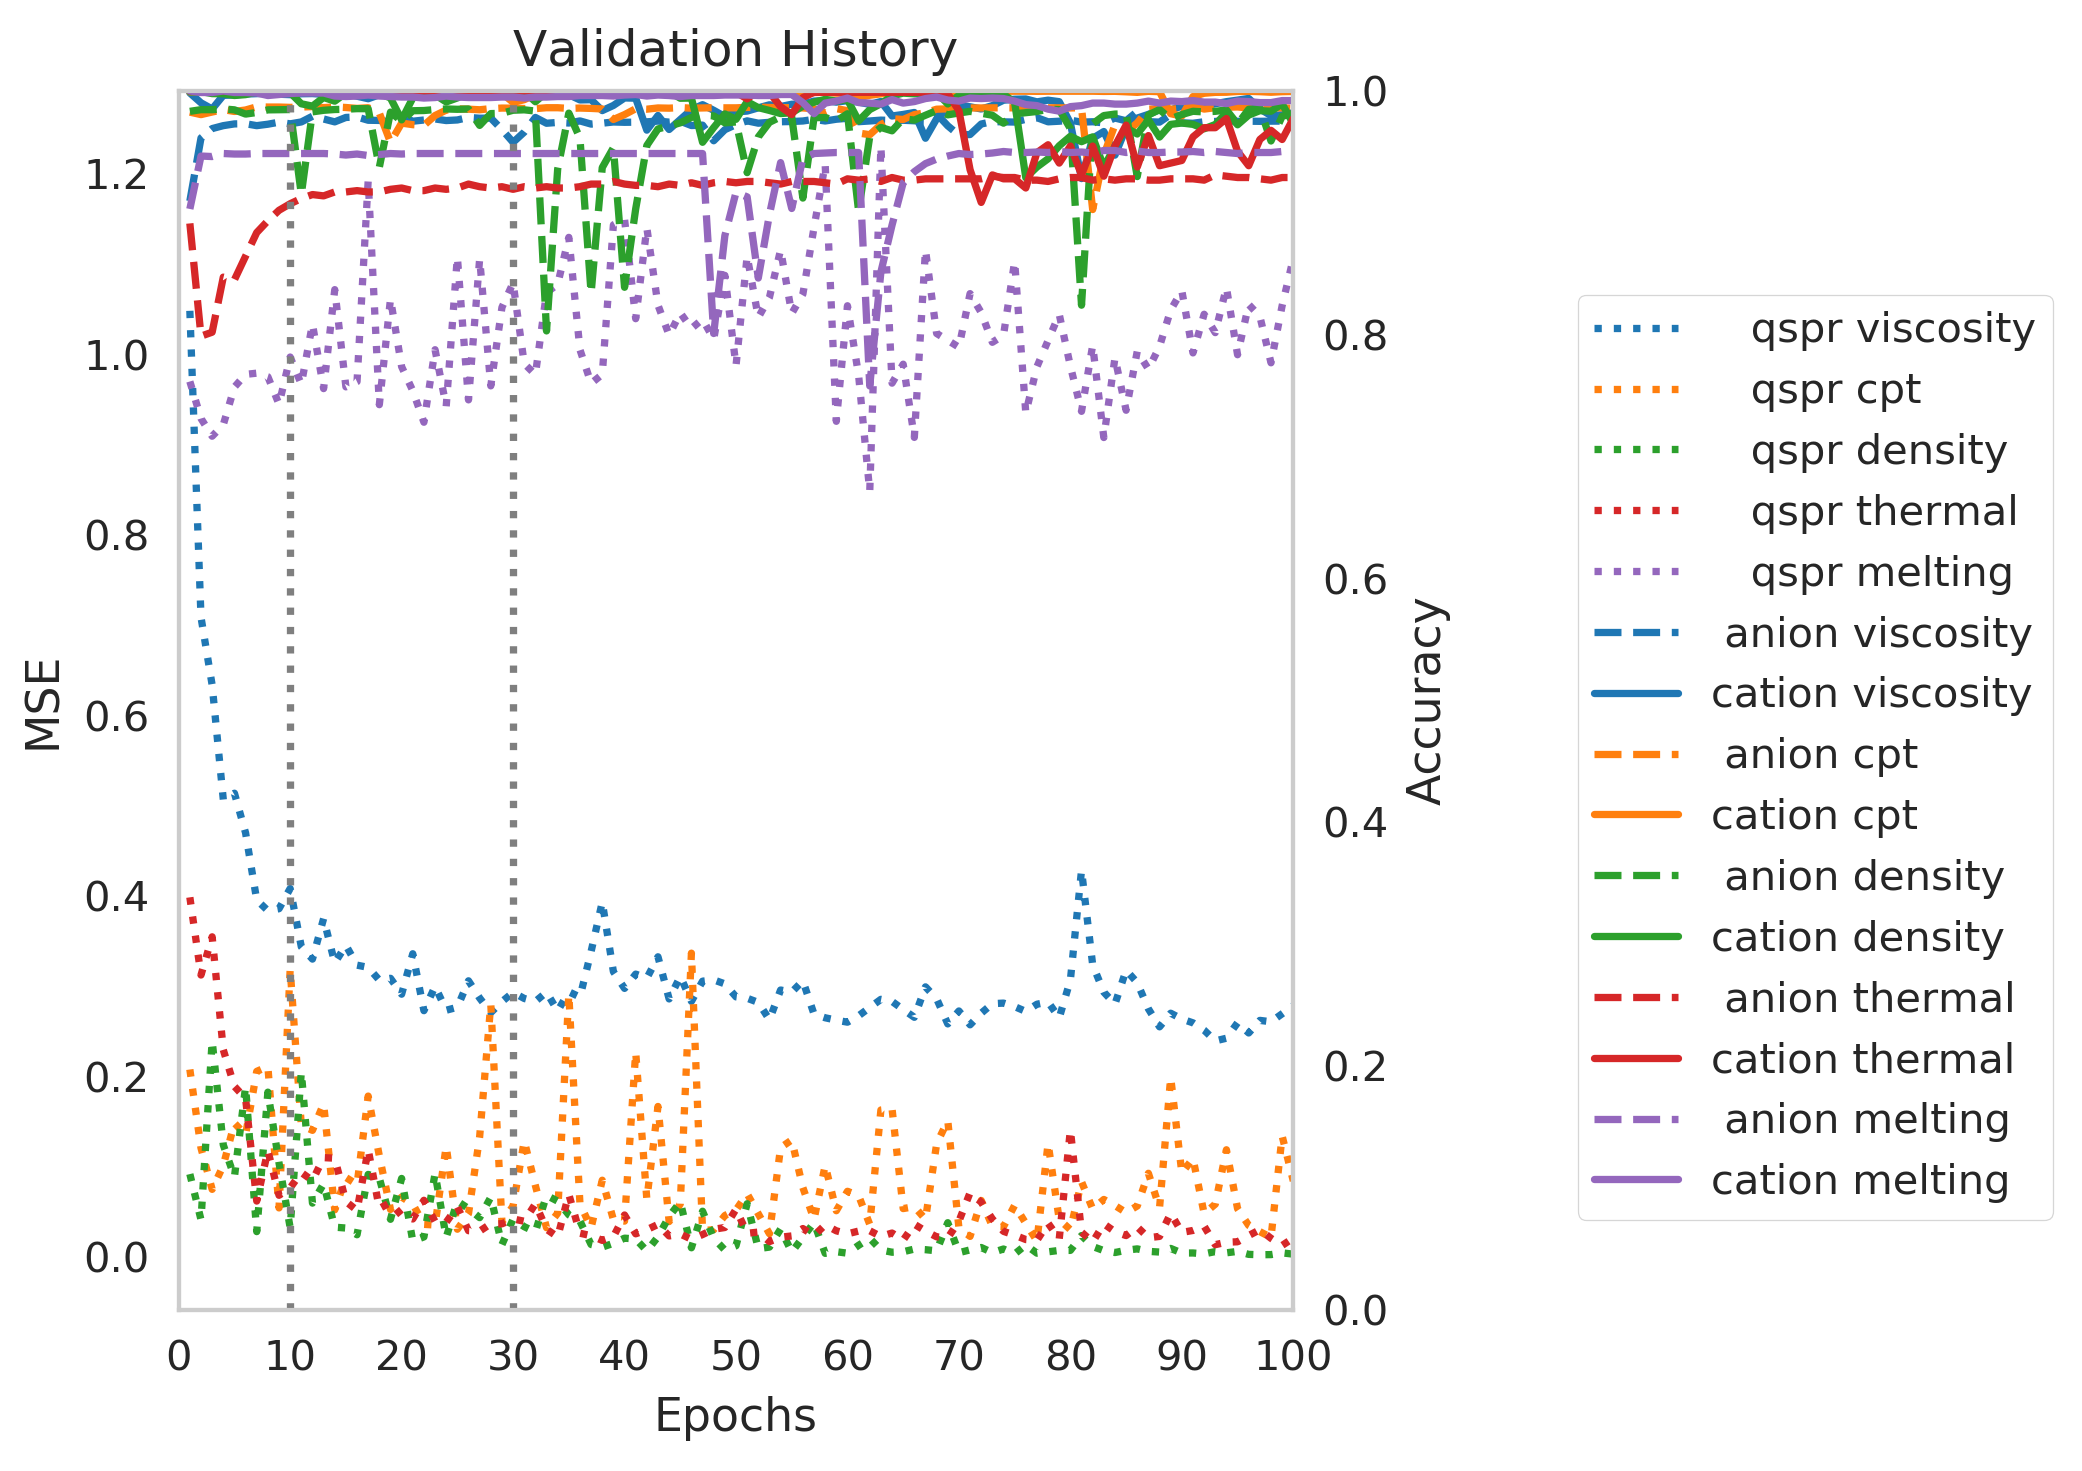

In [41]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    ax2 = ax.twinx()
    tab = my_colors()
    for i in range(5):
        col=next(tab)
        with open('../models/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)


        ax2.plot(np.arange(1,101,1), hist['val_anion_decoded_mean_acc'], ls='--', label=" anion {}".format(histories[i].split('_')[2]), c=col)
        ax2.plot(np.arange(1,101,1), hist['val_cation_decoded_mean_acc'], ls='-', label="cation {}".format(histories[i].split('_')[2]), c=col)
        ax.plot(np.arange(1,101,1), hist['val_qspr_mean_squared_error'], ls=':', label="   qspr {}".format(histories[i].split('_')[2]), c=col)
        
        ax.set_xlim(0,100,1)
        ax2.set_ylim(0,1)
#         ax2.set_ylim(0.7,1.1)
        
        ax.set_ylabel('MSE')
        ax2.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1+h2, l1+l2, frameon=True, bbox_to_anchor=(1.7, .85))
        
    ax2.plot([10,10],[0,1], ls=':', c='tab:grey')
    ax2.plot([30,30],[0,1], ls=':', c='tab:grey')
    
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    ax.set_title('Validation History')
    ax2.grid()
    ax.grid()
    fig.tight_layout()

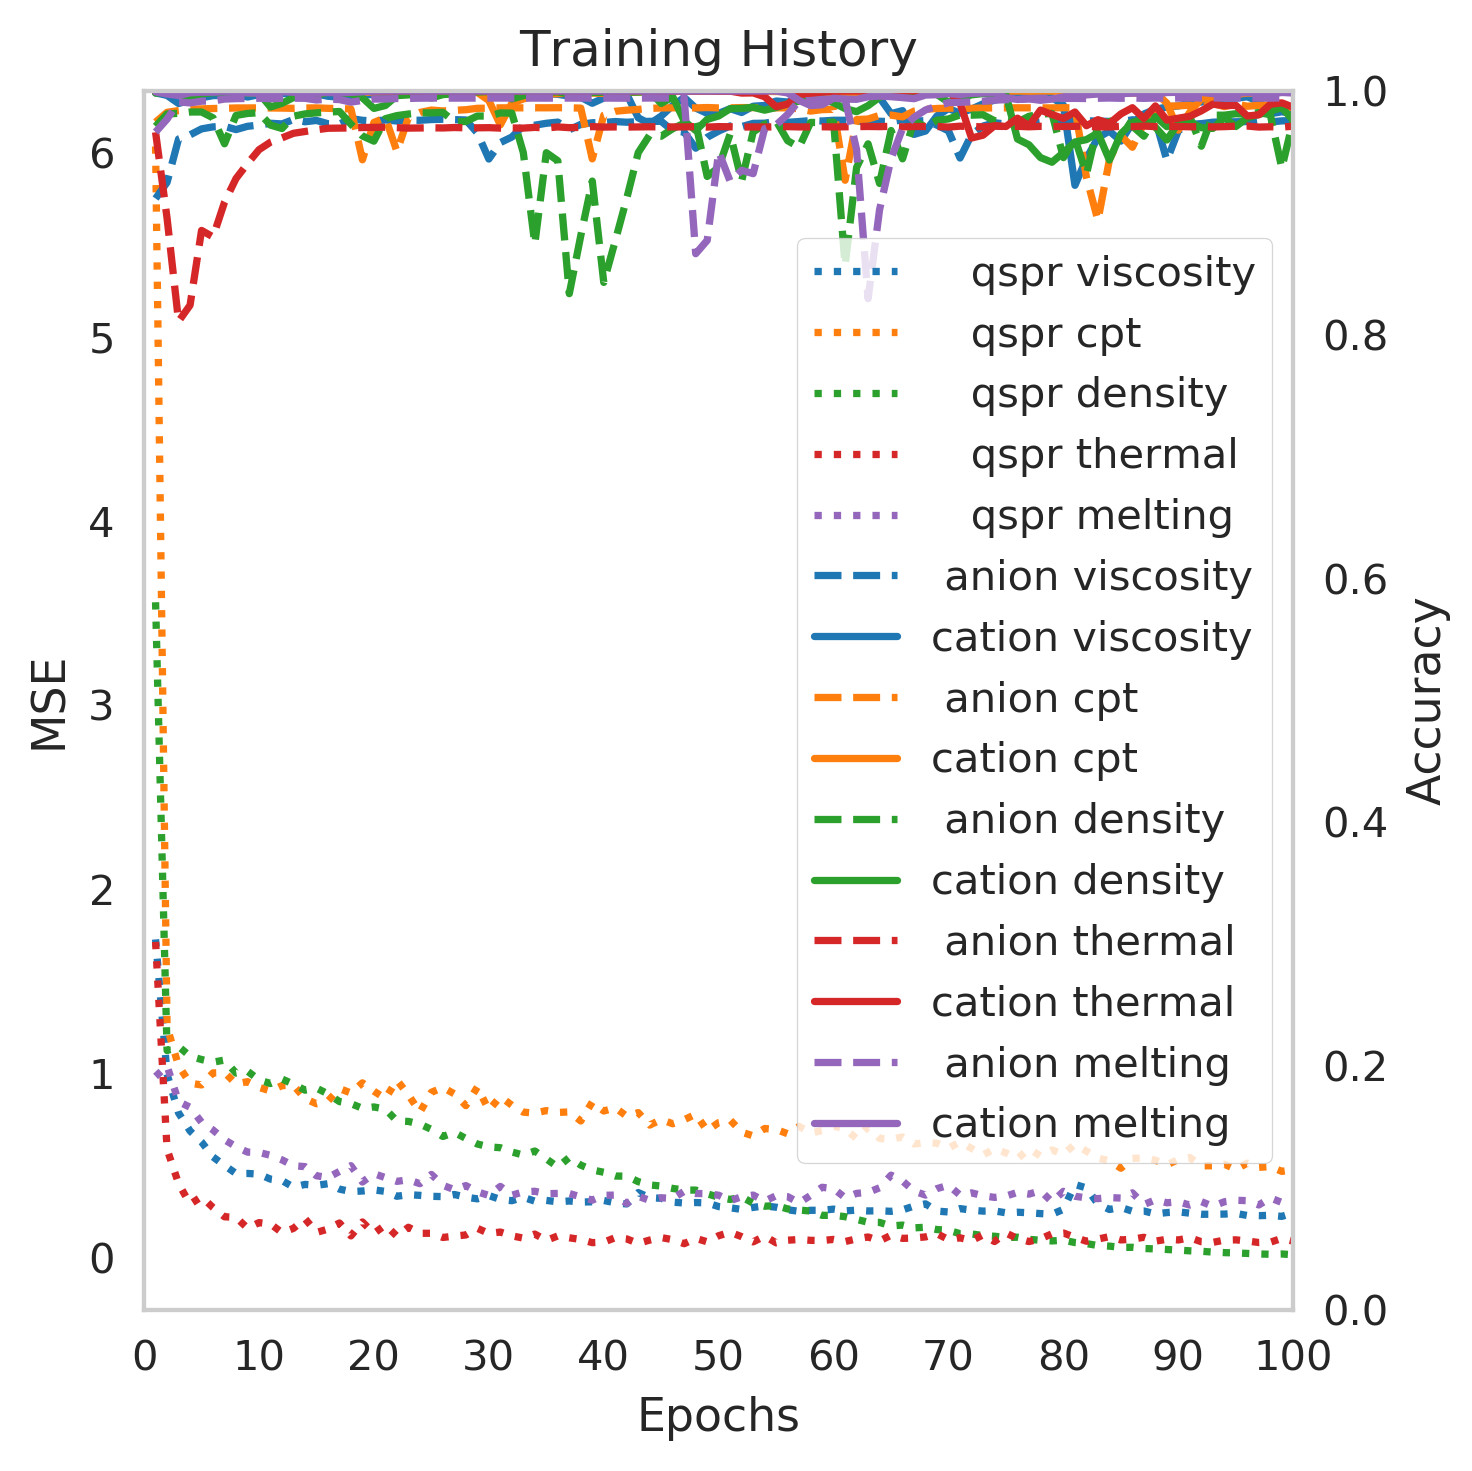

In [50]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    ax2 = ax.twinx()
    tab = my_colors()
    for i in range(5):
        col=next(tab)
        with open('../models/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)

        ax2.plot(np.arange(1,101,1), hist['anion_decoded_mean_acc'], ls='--', label=" anion {}".format(histories[i].split('_')[2]), c=col)
        ax2.plot(np.arange(1,101,1), hist['cation_decoded_mean_acc'], ls='-', label="cation {}".format(histories[i].split('_')[2]), c=col)
        ax.plot(np.arange(1,101,1), hist['qspr_mean_squared_error'], ls=':', label="   qspr {}".format(histories[i].split('_')[2]), c=col)
               
        ax.set_xlim(0,100,1)
        ax2.set_ylim(0,1)
        ax.set_ylabel('MSE')
        ax2.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1+h2, l1+l2, frameon=True, framealpha=0.8, loc='right')#, bbox_to_anchor=(1.7, .85))

    ax.set_title('Training History')
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    ax2.grid()
    ax.grid()
    fig.tight_layout()
#     plt.grid()


In [70]:
fig.savefig('assets/gen123_training_hist.svg', dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


history_gen1_2mol_1mil_GDB17_mix_pure.json
{'decoded_cation_mean_loss': [2.2092214672851562], 'decoded_cation_mean_acc': [0.7066377421483397], 'decoded_anion_mean_acc': [0.7067117740881443], 'decoded_anion_mean_loss': [2.211126968269348], 'loss': [4.4203484349823]}
{'decoded_cation_mean_loss': [2.158374296760559], 'decoded_cation_mean_acc': [0.7106159678840637], 'decoded_anion_mean_acc': [0.7125814513969422], 'decoded_anion_mean_loss': [2.131297709732056], 'loss': [4.289672004470825]}
{'decoded_cation_mean_loss': [2.1821408116149903], 'decoded_cation_mean_acc': [0.7093077417230607], 'decoded_anion_mean_acc': [0.7101222575187683], 'decoded_anion_mean_loss': [2.173652139968872], 'loss': [4.355792947998047]}
{'decoded_cation_mean_loss': [2.2234405721664428], 'decoded_cation_mean_acc': [0.7040672578239441], 'decoded_anion_mean_acc': [0.7026545160675048], 'decoded_anion_mean_loss': [2.248893270301819], 'loss': [4.472333840789795]}
{'decoded_cation_mean_loss': [2.129129978981018], 'decoded_c

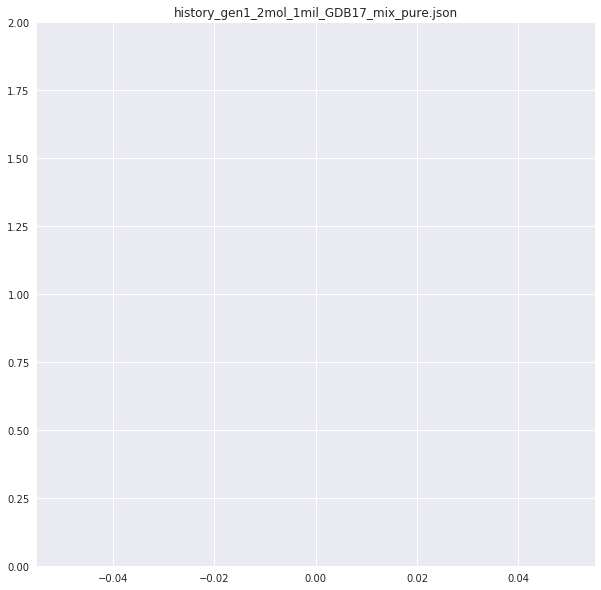

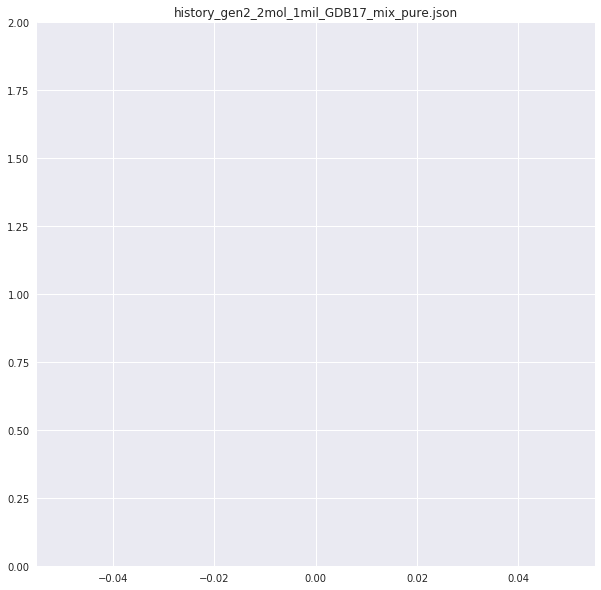

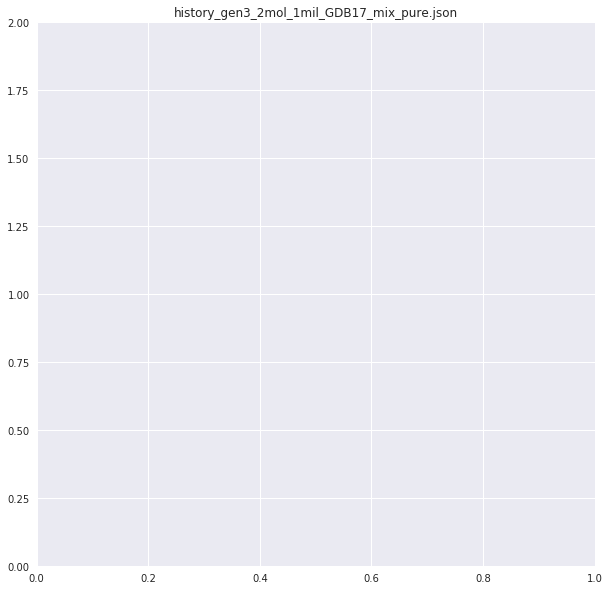

In [25]:
fig, ax = plt.subplots(1, figsize=(10,10))
histories.sort()            
for key, item in enumerate(histories):
    print(histories[key])
    f = open("../models/{}".format(histories[key]),"r")
    history = json.loads(f.read())
    for hist in history:
        print(hist)
        try:
            ax.plot(hist['decoded_cation_mean_acc'], label='val acc')
            ax.plot(hist['decoded_anion_mean_acc'], label = 'acc')
        except:
            ax.plot(hist['cation_decoded_mean_acc'], label='val acc')
            ax.plot(hist['anion_decoded_mean_acc'], label = 'acc')
            
        

    fig, ax = plt.subplots(1, figsize=(10,10))
    

    ax.set_ylim(0,2)
    ax.set_title(item)
    ax.legend()
#     except:pass

history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_5_2_viscosity_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_viscosity_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_viscosity_vae_100_epochs.json


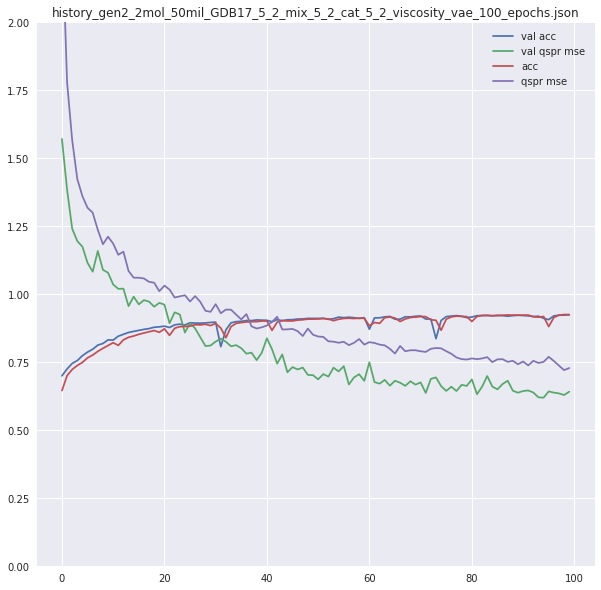

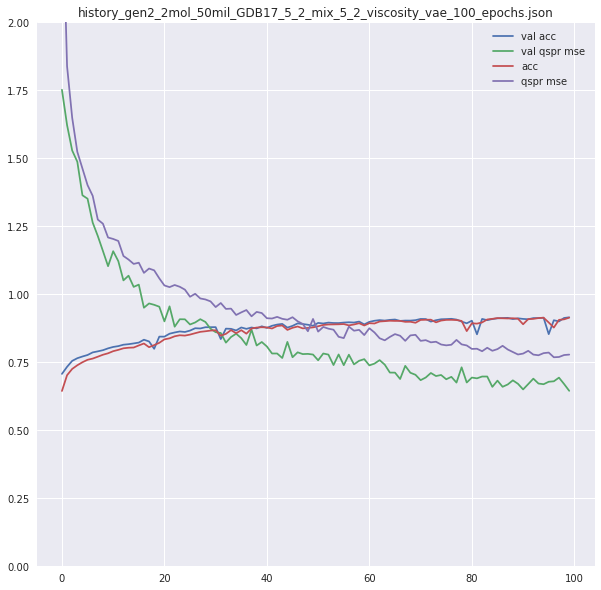

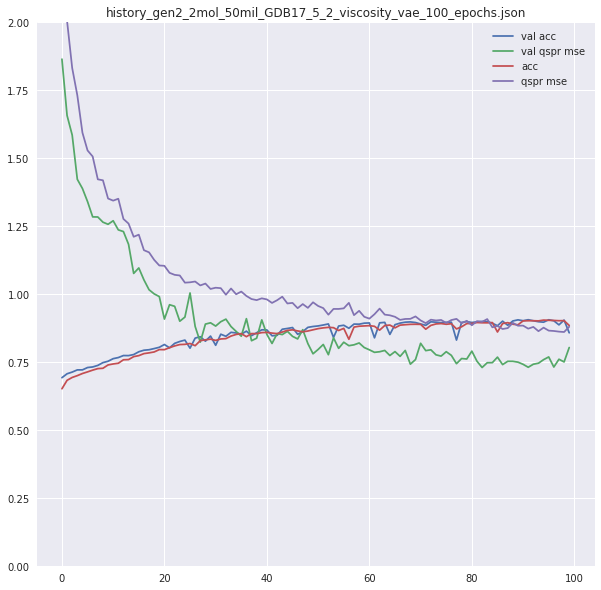

In [64]:
import os
histories = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if 'history' in filename:
            if '100' in filename:
                if 'viscosity' in filename:
                    histories.append(filename)
histories.sort()            
for key, item in enumerate(histories):
    try:
        print(histories[key])
        f = open("{}".format(histories[key]),"r")
        history = json.loads(f.read())

        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.plot(history['val_decoded_mean_acc'], label='val acc')
        ax.plot(history['val_qspr_mean_squared_error'], label ='val qspr mse')
        ax.plot(history['decoded_mean_acc'], label = 'acc')
        ax.plot(history['qspr_mean_squared_error'], label='qspr mse')
        ax.set_ylim(0,2)
        ax.set_title(item)
        ax.legend()
    except:pass

history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_5_2_viscosity_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_viscosity_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_viscosity_vae_100_epochs.json


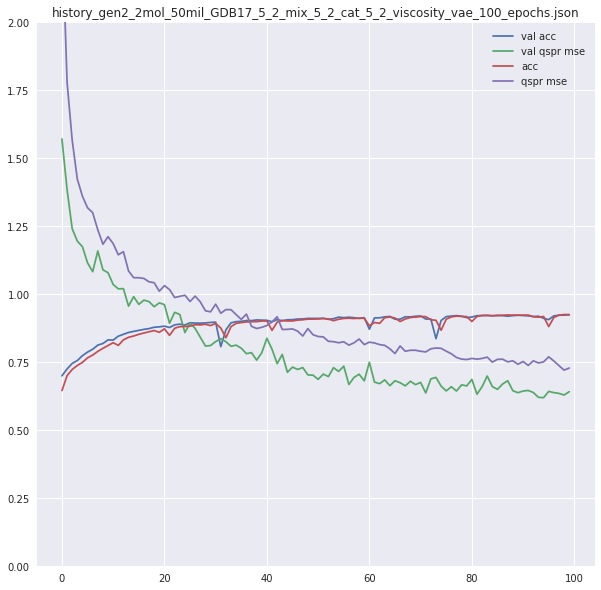

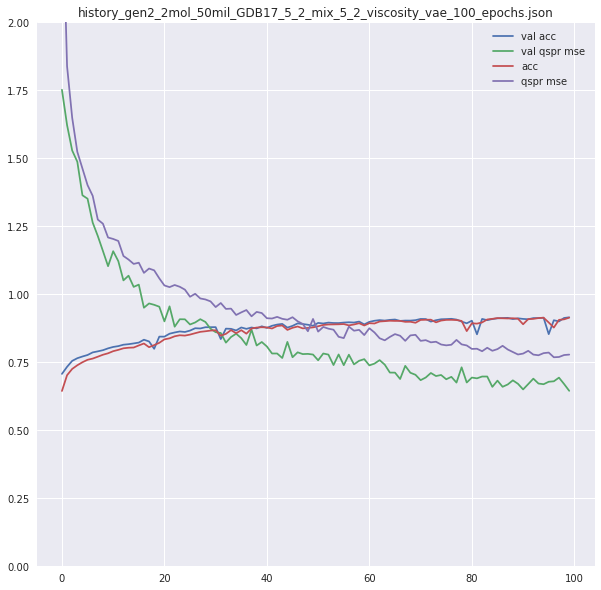

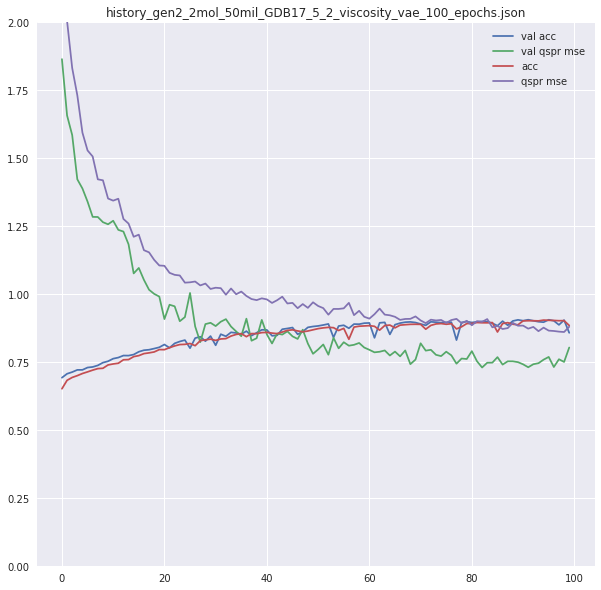

In [65]:
import os
histories = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if 'history' in filename:
            if '100' in filename:
                if 'viscosity' in filename:
                    histories.append(filename)
histories.sort()           
for key, item in enumerate(histories):
    try:
        print(histories[key])
        f = open("{}".format(histories[key]),"r")
        history = json.loads(f.read())

        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.plot(history['val_decoded_mean_acc'], label='val acc')
        ax.plot(history['val_qspr_mean_squared_error'], label ='val qspr mse')
        ax.plot(history['decoded_mean_acc'], label = 'acc')
        ax.plot(history['qspr_mean_squared_error'], label='qspr mse')
        ax.set_ylim(0,2)
        ax.set_title(item)
        ax.legend()
    except:pass

history_gen2_2mol_50mil_GDB17_5_2_cpt_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_5_2_cpt_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_cpt_vae_100_epochs.json


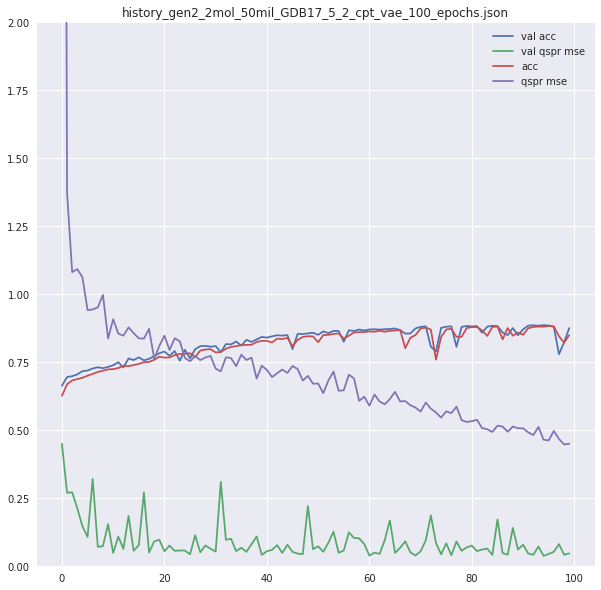

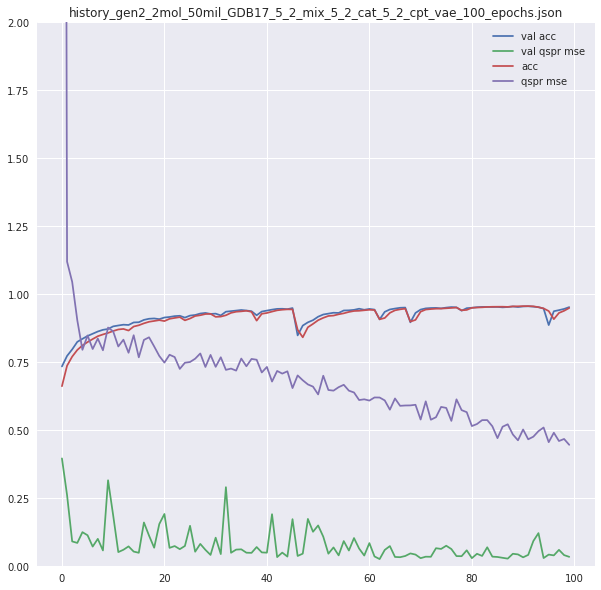

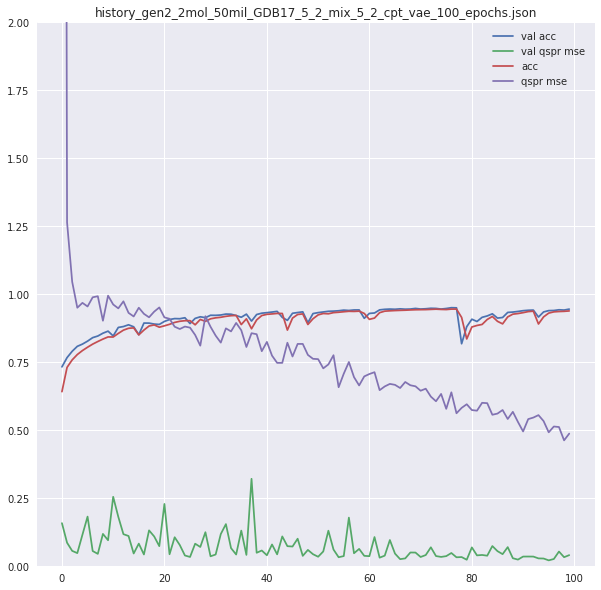

In [66]:
import os
histories = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if 'history' in filename:
            if '100' in filename:
                if 'cpt' in filename:
                    histories.append(filename)
histories.sort()           
for key, item in enumerate(histories):
    try:
        print(histories[key])
        f = open("{}".format(histories[key]),"r")
        history = json.loads(f.read())

        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.plot(history['val_decoded_mean_acc'], label='val acc')
        ax.plot(history['val_qspr_mean_squared_error'], label ='val qspr mse')
        ax.plot(history['decoded_mean_acc'], label = 'acc')
        ax.plot(history['qspr_mean_squared_error'], label='qspr mse')
        ax.set_ylim(0,2)
        ax.set_title(item)
        ax.legend()
    except:pass

history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_5_2_thermal_conductivity_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_thermal_conductivity_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_thermal_conductivity_vae_100_epochs.json


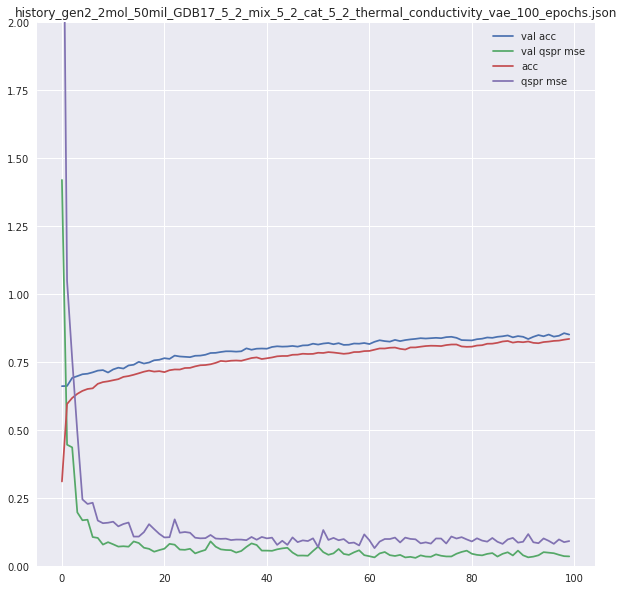

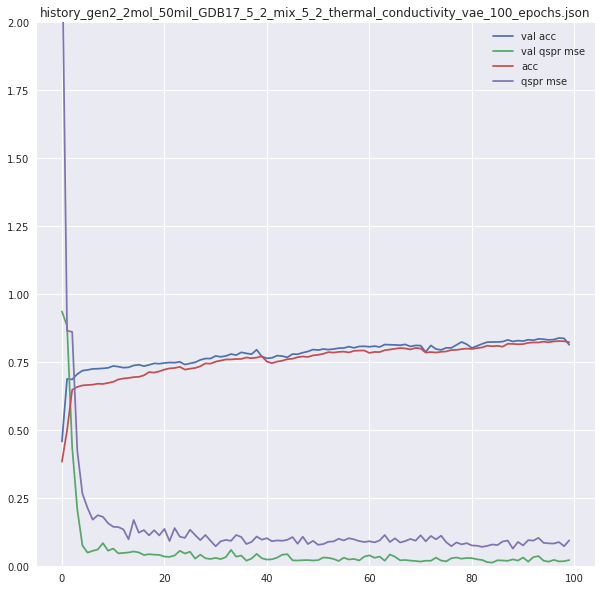

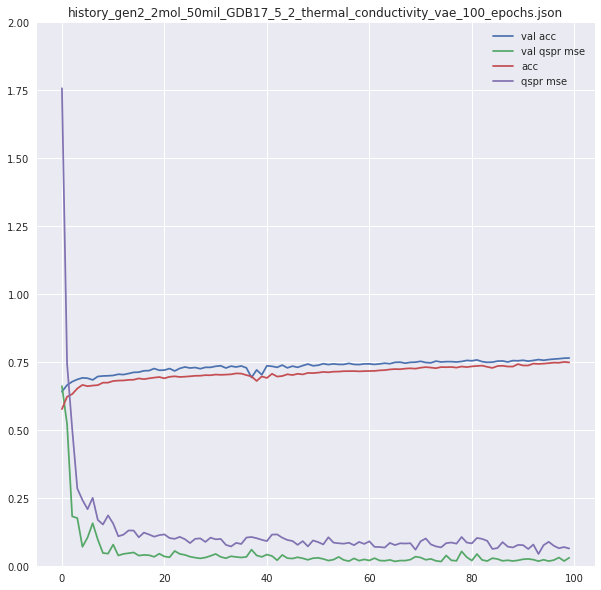

In [62]:
import os
histories = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if 'history' in filename:
            if '100' in filename:
                if 'thermal' in filename:
                    histories.append(filename)
histories.sort()        
for key, item in enumerate(histories):
    try:
        print(histories[key])
        f = open("{}".format(histories[key]),"r")
        history = json.loads(f.read())

        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.plot(history['val_decoded_mean_acc'], label='val acc')
        ax.plot(history['val_qspr_mean_squared_error'], label ='val qspr mse')
        ax.plot(history['decoded_mean_acc'], label = 'acc')
        ax.plot(history['qspr_mean_squared_error'], label='qspr mse')
        ax.set_ylim(0,2)
        ax.set_title(item)
        ax.legend()
    except:pass

history_gen2_2mol_50mil_GDB17_5_2_melting_point_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_cat_5_2_melting_point_vae_100_epochs.json
history_gen2_2mol_50mil_GDB17_5_2_mix_5_2_melting_point_vae_100_epochs.json


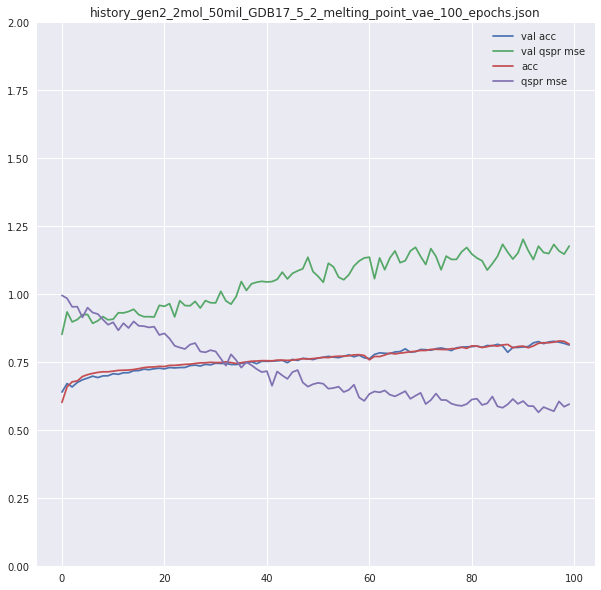

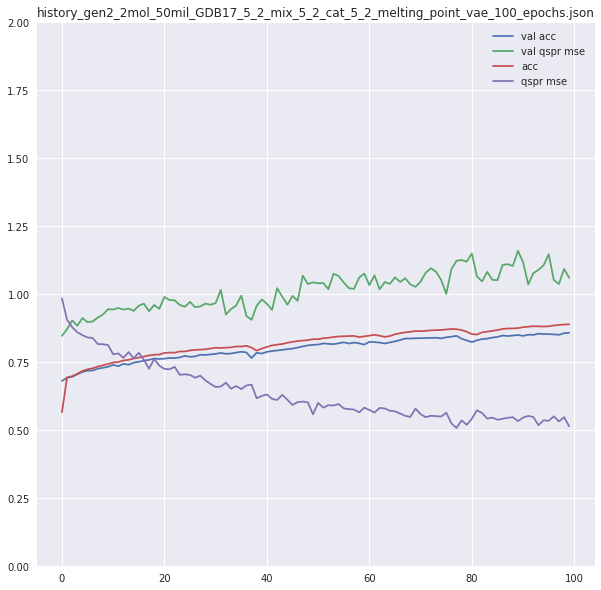

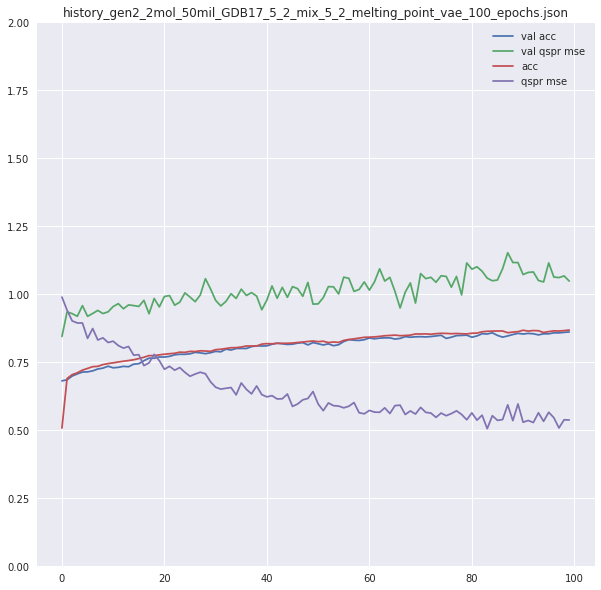

In [67]:
import os
histories = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if 'history' in filename:
            if '100' in filename:
                if 'melting' in filename:
                    histories.append(filename)
            
for key, item in enumerate(histories):
    try:
        print(histories[key])
        f = open("{}".format(histories[key]),"r")
        history = json.loads(f.read())

        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.plot(history['val_decoded_mean_acc'], label='val acc')
        ax.plot(history['val_qspr_mean_squared_error'], label ='val qspr mse')
        ax.plot(history['decoded_mean_acc'], label = 'acc')
        ax.plot(history['qspr_mean_squared_error'], label='qspr mse')
        ax.set_ylim(0,2)
        ax.set_title(item)
        ax.legend()
    except:pass

Text(0.5,1,'First Million GDB, 2 molecule output')

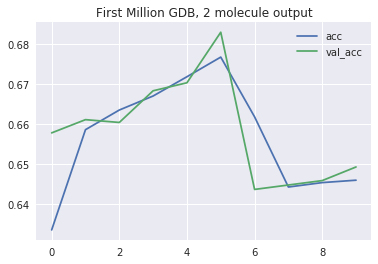

In [78]:
#first million
phase_1a_history = {'acc': [0.6336, 0.6586, 0.6635, 0.6670, 0.6718, 0.6767, 0.6618, 0.6443, 0.6454, 0.6460],
                   'val_acc': [0.6578, 0.6611, 0.6604, 0.6683, 0.6703, 0.6829, 0.6437, 0.6448, 0.6459, 0.6493]}
plt.plot(phase_1a_history['acc'], label='acc')
plt.plot(phase_1a_history['val_acc'], label='val_acc')
plt.legend()
plt.title('First Million GDB, 2 molecule output')

Text(0.5,1,'6 million GDB, 2 molecule output')

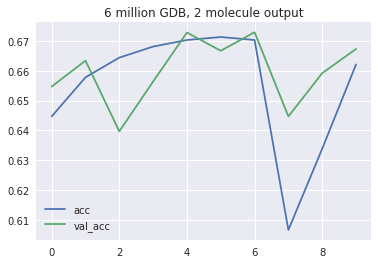

In [80]:
#1-6million
phase_1b_history = {'acc': [0.6447, 0.6578, 0.6644, 0.6681, 0.6703, 0.6713, 0.6703, 0.6067, 0.6339, 0.6621],
                   'val_acc': [0.6547, 0.6634, 0.6397, 0.6564, 0.6728, 0.6667, 0.6729, 0.6447, 0.6592, 0.6673]}
plt.plot(phase_1b_history['acc'], label='acc')
plt.plot(phase_1b_history['val_acc'], label='val_acc')
plt.legend()
plt.title('6 million GDB, 2 molecule output')

Text(0.5,1,'5 million mix training, 2 molecule output')

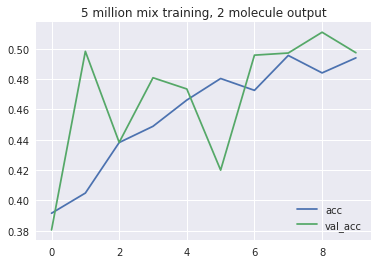

In [81]:
phase_2_history = {'acc': [0.3916, 0.4049, 0.4382, 0.4489, 0.4662, 0.4804, 0.4726, 0.4956, 0.4841, 0.4940],
                   'val_acc': [0.3806, 0.4983, 0.4383, 0.4809, 0.4735, 0.4200, 0.4958, 0.4972, 0.5109, 0.4974]}
plt.plot(phase_2_history['acc'], label='acc')
plt.plot(phase_2_history['val_acc'], label='val_acc')
plt.legend()
plt.title('5 million mix training, 2 molecule output')

Text(0.5,1,'5 million salt training, 2 molecule output')

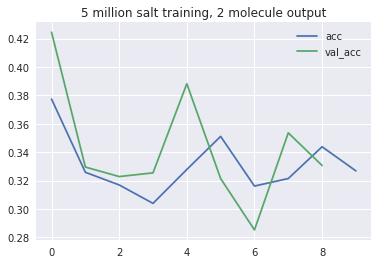

In [82]:
phase_3_history = {'acc': [0.3774, 0.3258, 0.3169, 0.3039, 0.3278, 0.3511, 0.3161, 0.3214, 0.3438, 0.3268],
                   'val_acc': [0.4245, 0.3295, 0.3228, 0.3254, 0.3882, 0.3214, 0.2852, 0.3536, 0.3306]}
plt.plot(phase_3_history['acc'], label='acc')
plt.plot(phase_3_history['val_acc'], label='val_acc')
plt.legend()
plt.title('5 million salt training, 2 molecule output')

Text(0.5,1,'First Million GDB, 1 molecule output')

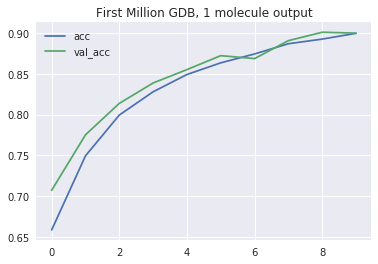

In [83]:
single_phase_1_history = {'acc': [0.6586, 0.7494, 0.7994, 0.8279, 0.8491, 0.8634, 0.8743, 0.8868, 0.8925, 0.8996],
                   'val_acc': [0.7072, 0.7752, 0.8137, 0.8387, 0.8551, 0.8722, 0.8686, 0.8906, 0.9009, 0.8998]}
plt.plot(single_phase_1_history['acc'], label='acc')
plt.plot(single_phase_1_history['val_acc'], label='val_acc')
plt.legend()
plt.title('First Million GDB, 1 molecule output')

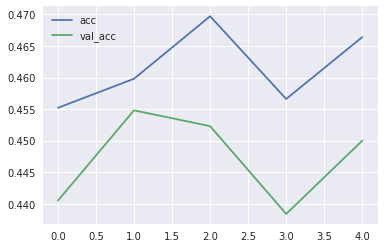

In [85]:
single_phase_3_history = {'acc': [0.4552, 0.4598, 0.4697, 0.4566, 0.4664],
                   'val_acc': [0.4405, 0.4548, 0.4523, 0.4384, 0.4500]}
plt.plot(single_phase_3_history['acc'], label='acc')
plt.plot(single_phase_3_history['val_acc'], label='val_acc')
plt.legend()